In [1]:
%load_ext autoreload
%autoreload 2

from code_py.DIAMOnD import *
from code_py.backbone import Human_Genes_Graph_Analysis
import markov_clustering as mc
from joblib import Parallel, delayed
import statistics 
from tqdm import tqdm

sys_path = '/Users/tanselsimsek/Desktop/DS/2.1/BI/Final_project/'


#  Part 1: Preprocessing

In [2]:
disease_code = "C0020796"
hga = Human_Genes_Graph_Analysis(sys_path,disease_ID = disease_code)

#### 1.1 -- Filtering and removing self-loops

In [3]:
# Preprocessing the Biogrid dataset by filtering Homo Sapiens, removing duplicated and self loops
hs_putative_genes = hga.preprocessing_dataset(homo_sap=True,drop_duplicates=True,remove_self_loops=True)

Number of putative genes: 889884


#### 1.2 -- Filtering Disease Genes

In [4]:
hs_disease_genes_df,hs_disease_genes = hga.query_disease_genes()

Found 139 disease genes in Profound Mental Retardation


#### 1.3 -- Creating LCC sub-graph,adjacency matrix,

In [5]:
# We are creating the graph with nx from the from the filtered PPI dataset and returning the sub graph, adj matrix, nodes and edges of LCC 
pgenes_sub_graph,pgenes_adj,pnodes,pedges = hga.LCC_to_adj(hs_putative_genes)

# of connected components: 1
19618
Name: 
Type: Graph
Number of nodes: 19618
Number of edges: 665061
Average degree:  67.8011


#### 1.3 -- Cross Validation

In [6]:
ds_genes_train,ds_genes_test = hga.KFold_CV(hs_disease_genes,n_folds=5,shuffle_flag=True)

#### 1.4 -- Saving Seed Genes to files for Cytoscape

In [9]:
for i in range(len(ds_genes_test)):
    np.savetxt("test"+str(i)+".csv", 
            ds_genes_test[i],
            delimiter =", ", 
            fmt ='% s')
    np.savetxt("train"+str(i)+".csv", 
            ds_genes_train[i],
            delimiter =", ", 
            fmt ='% s')

# Part 2: Algorithms  

### 2.1 -- MCL Algorithm 

In [14]:
# Applying MLC Algoritm by given inflation range (1.5, 2.7, step = 0.1)
results = Parallel(n_jobs=3)(delayed(hga.MCL)(pgenes_adj,i) for i in tqdm(np.arange(1.5,2.7,0.1)))


100%|██████████| 13/13 [7:31:19<00:00, 2083.00s/it] 


In [15]:
hga.list_to_pikle(results,'MLC_modularity')

In [16]:
results_list_from_pkl = hga.read_pickle_list('MLC_modularity')
for i in enumerate(np.arange(1.5,2.7,0.1)):
    print("inflation:", round(i[1],2), "modularity:", results_list_from_pkl[i[0]])
    

inflation: 1.5 modularity: 0.7318793908083768
inflation: 1.6 modularity: 0.7664038191128469
inflation: 1.7 modularity: 0.7948113431834943
inflation: 1.8 modularity: 0.8254253707325344
inflation: 1.9 modularity: 0.8034790682066575
inflation: 2.0 modularity: 0.7514658577401434
inflation: 2.1 modularity: 0.6951036602617071
inflation: 2.2 modularity: 0.641935117124079
inflation: 2.3 modularity: 0.5919604667312881
inflation: 2.4 modularity: 0.5541978925627196
inflation: 2.5 modularity: 0.5206722692342249
inflation: 2.6 modularity: 0.49161128642816465
inflation: 2.7 modularity: 0.46866783664642075


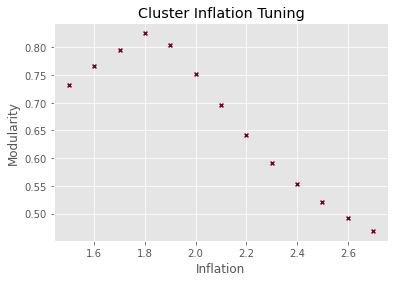

In [46]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

x = np.arange(1.5,2.7,0.1)
y = results_list_from_pkl
plt.scatter(x,y,color="#7b002c",s=15,marker='x')
x,y = 1.7, 0.4
plt.xlabel("Inflation")
plt.ylabel("Modularity")
plt.title('Cluster Inflation Tuning')
plt.show()

### 2.1.1 -- Creating Clusters

In [11]:
best_inflation = 1.8
result = mc.run_mcl(pgenes_adj, inflation=best_inflation)
clusters = mc.get_clusters(result)
print(str(len(clusters))+" of clusters obtained with inflation of "+str(best_inflation))

2106 of clusters obtained with inflation of 1.8


In [12]:
_, enriched_genes,enriched_cluster_ID = hga.MLC_eval(pgenes_sub_graph,ds_genes_train,clusters)

Fold number:  0
6 disease genes in cluster 0 --> 0.165607
35 disease genes in cluster 2 --> 0.013666
3 disease genes in cluster 6 --> 0.217906
6 disease genes in cluster 11 --> 0.165457
3 disease genes in cluster 27 --> 0.034026
4 disease genes in cluster 46 --> 0.154399
7 disease genes in cluster 53 --> 0.115389
3 disease genes in cluster 68 --> 0.127471
Fold number:  1
5 disease genes in cluster 0 --> 0.164454
40 disease genes in cluster 2 --> 0.001084
3 disease genes in cluster 6 --> 0.217906
6 disease genes in cluster 11 --> 0.165457
8 disease genes in cluster 53 --> 0.073821
3 disease genes in cluster 67 --> 0.22377
3 disease genes in cluster 68 --> 0.127471
Fold number:  2
3 disease genes in cluster 0 --> 0.087338
34 disease genes in cluster 2 --> 0.020074
4 disease genes in cluster 6 --> 0.136394
7 disease genes in cluster 11 --> 0.139195
10 disease genes in cluster 53 --> 0.020798
3 disease genes in cluster 67 --> 0.22377
3 disease genes in cluster 68 --> 0.127471
Fold number: 

In [66]:
hga.MCL_evaluation_metrics(pgenes_sub_graph,ds_genes_test,hs_disease_genes,clusters,enriched_cluster_ID)

TP: 51 --- FP: 2055 --- FN: 19567
Precision: 0.024217 --- Recall: 0.0026 --- F1 Score: 0.004695


### 2.2 -- DIAMOnD Algorithm

In [7]:
hga.return_metrics("DIAMOnD", pgenes_sub_graph, hs_disease_genes, ds_genes_train, ds_genes_test, print_flag=True)

DIAMOnD(): ignoring 5 of 111 seed genes that are not in the network
DiaBLE(): ignoring 5 of 111 seed genes that are not in the network
DIAMOnD(): ignoring 3 of 111 seed genes that are not in the network
DiaBLE(): ignoring 3 of 111 seed genes that are not in the network
DIAMOnD(): ignoring 4 of 111 seed genes that are not in the network
DiaBLE(): ignoring 4 of 111 seed genes that are not in the network
DIAMOnD(): ignoring 4 of 111 seed genes that are not in the network
DiaBLE(): ignoring 4 of 111 seed genes that are not in the network
DIAMOnD(): ignoring 4 of 112 seed genes that are not in the network
DiaBLE(): ignoring 4 of 112 seed genes that are not in the network
zero division
zero division
zero division
zero division
zero division
zero division
zero division
zero division
zero division
zero division
zero division
zero division
zero division
zero division
zero division
zero division
Precision at 50: 0.001802 ± 0.004029
Precision at n/10: 0.001802 ± 0.004029
Precision at n/4: 0.00180

### 2.3 -- DiaBLE Algorithm

In [8]:
hga.return_metrics("DiaBLE", pgenes_sub_graph, hs_disease_genes, ds_genes_train, ds_genes_test, print_flag=True)

DiaBLE(): ignoring 5 of 111 seed genes that are not in the network
DiaBLE(): ignoring 3 of 111 seed genes that are not in the network
DiaBLE(): ignoring 4 of 111 seed genes that are not in the network
DiaBLE(): ignoring 4 of 111 seed genes that are not in the network
DiaBLE(): ignoring 4 of 112 seed genes that are not in the network
zero division
zero division
zero division
zero division
zero division
zero division
zero division
zero division
zero division
zero division
zero division
zero division
zero division
zero division
zero division
zero division
Precision at 50: 0.001802 ± 0.004029
Precision at n/10: 0.001802 ± 0.004029
Precision at n/4: 0.001802 ± 0.004029
Precision at n/2: 0.003604 ± 0.004934
Precision at n: 0.008993 ± 0.00637
Recall at 50: 0.007143 ± 0.015972
Recall at n/10: 0.007143 ± 0.015972
Recall at n/4: 0.007143 ± 0.015972
Recall at n/2: 0.014286 ± 0.019562
Recall at n: 0.035979 ± 0.025261
F1 Score at 50: 0.014388
F1 Score at n/10: 0.014388
F1 Score at n/4: 0.014388
F1 

### 2.4 -- Cytoscape

In [9]:
hga.return_metrics("cytoscape", pgenes_sub_graph, hs_disease_genes, ds_genes_train, ds_genes_test, print_flag=True)

zero division
zero division
zero division
zero division
zero division
zero division
zero division
zero division
zero division
zero division
zero division
zero division
zero division
zero division
zero division
zero division
zero division
zero division
zero division
zero division
zero division
zero division
zero division
zero division
zero division
Precision at 50: 0.0 ± 0.0
Precision at n/10: 0.0 ± 0.0
Precision at n/4: 0.0 ± 0.0
Precision at n/2: 0.0 ± 0.0
Precision at n: 0.0 ± 0.0
Recall at 50: 0.0 ± 0.0
Recall at n/10: 0.0 ± 0.0
Recall at n/4: 0.0 ± 0.0
Recall at n/2: 0.0 ± 0.0
Recall at n: 0.0 ± 0.0
No values to record F1
No values to record F1
No values to record F1
No values to record F1
No values to record F1
nDCG at 50: 0.0 ± 0.0
nDCG at n/10: 0.0 ± 0.0
nDCG at n/4: 0.0 ± 0.0
nDCG at n/2: 0.0 ± 0.0
nDCG at n: 0.0 ± 0.0


### 2.6 -- Random Walk with Restart 

In [10]:
hga.return_metrics("rwr", pgenes_sub_graph, hs_disease_genes, ds_genes_train, ds_genes_test, print_flag=True)

zero division
zero division
zero division
zero division
zero division
zero division
zero division
zero division
zero division
zero division
zero division
zero division
zero division
zero division
zero division
zero division
zero division
zero division
zero division
zero division
zero division
zero division
zero division
zero division
zero division
Precision at 50: 0.0 ± 0.0
Precision at n/10: 0.0 ± 0.0
Precision at n/4: 0.0 ± 0.0
Precision at n/2: 0.0 ± 0.0
Precision at n: 0.0 ± 0.0
Recall at 50: 0.0 ± 0.0
Recall at n/10: 0.0 ± 0.0
Recall at n/4: 0.0 ± 0.0
Recall at n/2: 0.0 ± 0.0
Recall at n: 0.0 ± 0.0
No values to record F1
No values to record F1
No values to record F1
No values to record F1
No values to record F1
nDCG at 50: 0.0 ± 0.0
nDCG at n/10: 0.0 ± 0.0
nDCG at n/4: 0.0 ± 0.0
nDCG at n/2: 0.0 ± 0.0
nDCG at n: 0.0 ± 0.0


# Part 3: Extented Validation  

In [27]:
all_gene_disease = hga.query_disease_genes_extendend()